In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import scipy.io as scio

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
border = 5

In [3]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [5]:
mask = img_to_array(load_img("d:/Data/masks/0a1742c740.png"))

In [6]:
# tqdm 显示进度条
for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # 导入图片
    img = load_img("d:/Data/images/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("d:/Data/masks/"+id_))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [7]:
X.shape

(4000, 128, 128, 1)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(3600, 128, 128, 1) (3600, 128, 128, 1)
(400, 128, 128, 1) (400, 128, 128, 1)


Text(0.5, 1.0, 'Salt')

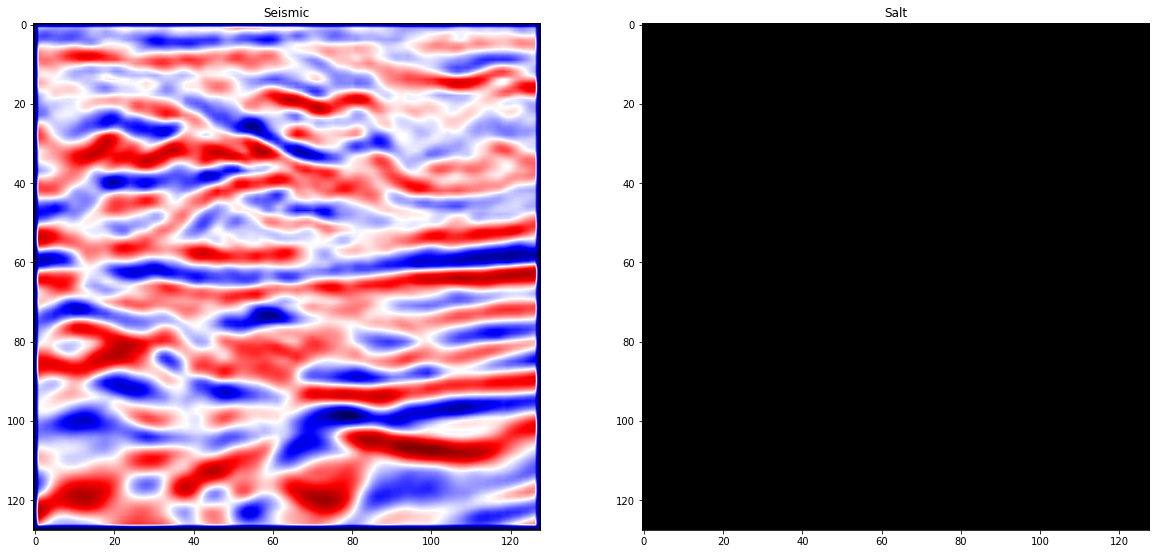

In [10]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # 是否存在盐体

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: 
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
X_train.shape

(3600, 128, 128, 1)

In [17]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 33s 9ms/step - loss: 0.4116 - accuracy: 0.6959 - val_loss: 2.1294 - val_accuracy: 0.3845

Epoch 00001: val_loss improved from inf to 2.12938, saving model to model-tgs-salt.h5
Epoch 2/50
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3194 - accuracy: 0.7174 - val_loss: 0.7388 - val_accuracy: 0.4955

Epoch 00002: val_loss improved from 2.12938 to 0.73884, saving model to model-tgs-salt.h5
Epoch 3/50
3600/3600 [==============================] - 27s 7ms/step - loss: 0.2942 - accuracy: 0.7235 - val_loss: 0.5512 - val_accuracy: 0.5820

Epoch 00003: val_loss improved from 0.73884 to 0.55120, saving model to model-tgs-salt.h5
Epoch 4/50
3600/3600 [==============================] - 27s 7ms/step - loss: 0.2829 - accuracy: 0.7264 - val_loss: 0.3228 - val_accuracy: 0.7075

Epoch 00004: val_loss improved from 0.55120 to 0.32276, saving model to model-tgs-salt.h5
Epoch 5/50
36

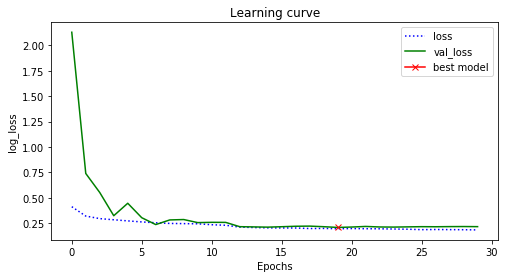

In [18]:
plt.figure(figsize=(8, 4))
plt.title("Learning curve")
plt.plot(results.history["loss"], c='b', linestyle=':', label="loss")
plt.plot(results.history["val_loss"], c='g', label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [19]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

400/400 [==============================] - 1s 2ms/step


[0.21521949291229248, 0.733555018901825]

In [20]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [21]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [22]:
def plot_sample(X, y, preds, binary_preds, ix=None):

    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

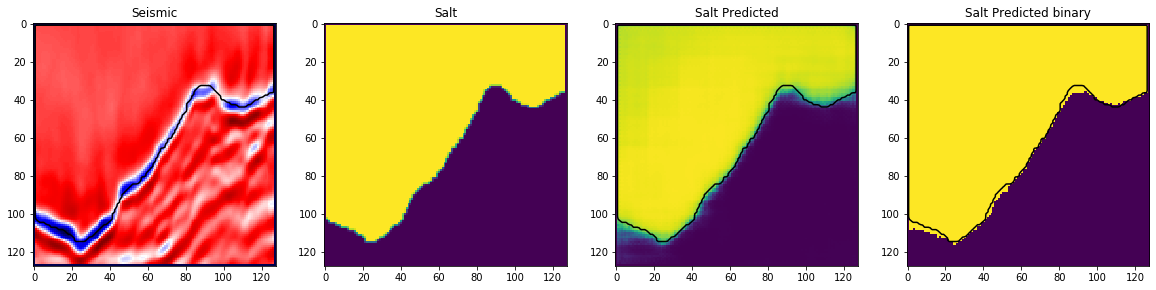

In [23]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=2)

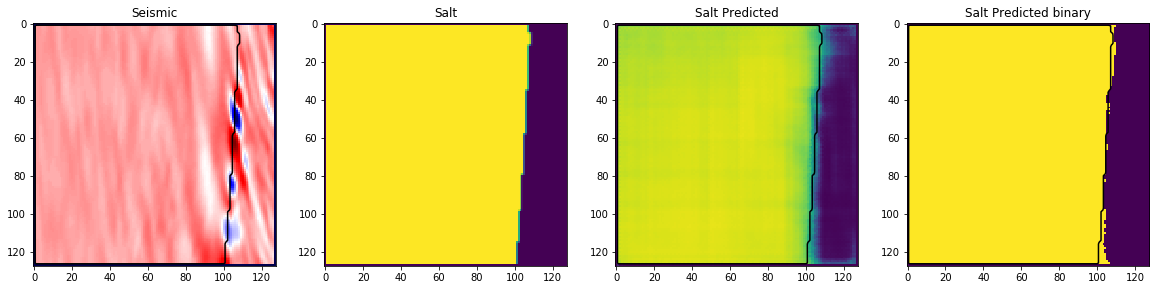

In [24]:
plot_sample(X_train, y_train, preds_train, preds_train_t)